In [1]:
import pandas as pd 
import numpy as np 
import geopandas as gpd
import h3
import matplotlib.pyplot as plt
from shapely import wkt
import orca

## Preprocessing the original MPO .shp files with TAZ 
Objective: Get area type as: 
- 0: Regional core
- 1: CBD
- 2: Urban Business
- 3: Urban
- 4: Suburban
- 5: Rural

In [2]:
#Load MPO TAZs shapefiles
mpo_taz = gpd.read_file('tazs_austin/2015_2045 CAMPO TAZ SHAPE.shp')
mpo_taz = mpo_taz.to_crs('EPSG:4326')

In [3]:
#Transformation values: 
mpo_taz = mpo_taz[mpo_taz.SMTDNAME != 'OutofArea']
area_type_dict = {'CBD': 1, 'UrbIntTravis': 2, 'UrbTravis': 3, 
                  'SubTravis': 4, 'RurTravis':5,'UrbIntWilliamson': 2,
                  'UrbWilliamson': 3, 'SubWilliamson': 4,'RurWilliamson': 5,
                  'UrbIntHays': 2, 'UrbHays': 3, 'SubHays': 4, 'RurHays': 5,
                  'UrbIntBastrop': 2, 'UrbBastrop': 3, 'SubBastrop': 4,
                  'RurBastrop': 5, 'UrbCaldwell': 3, 'SubCaldwell': 4, 
                  'RurCaldwell': 5, 'UrbBurnet': 3,'SubBurnet':4, 'RurBurnet':5} #Triangle shapes that are not in the region

mpo_taz['area_type'] = mpo_taz.SMTDNAME.replace(area_type_dict)

In [4]:
#Transform geopandas to dataframe
mpo_taz = pd.DataFrame(mpo_taz)
mpo_taz['geometry'] = mpo_taz.geometry.astype('str')

## Store MPO TAZs in the .h5 file

In [5]:
# hdf = pd.HDFStore('model_data.h5')
# hdf.append(key = 'mpo_taz', value = mpo_taz)
# hdf.close()

## Load MPO TAZ file and transform it to a geoDataFrame

In [6]:
hdf = pd.HDFStore('model_data.h5')

In [7]:
mpo_taz = hdf['/mpo_taz']
mpo_taz['geometry'] = mpo_taz['geometry'].apply(wkt.loads)
mpo_taz = gpd.GeoDataFrame(mpo_taz, geometry='geometry', crs ='EPSG:4326')

## Merge H3 hexbins and MPO TAZ

In [8]:
h3_gpd = gpd.read_file('h3_hexbis.shp')
h3_gpd.set_index('TAZ', inplace = True)

In [9]:
join = gpd.sjoin(h3_gpd, mpo_taz[['geometry','area_type','ACRES']], how = 'left',op='intersects')

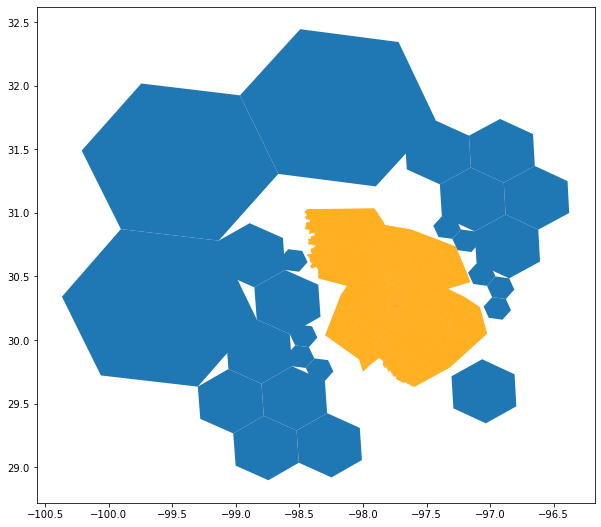

In [10]:
fig, ax = plt.subplots(figsize = (10,10))
join[join.area_type.isnull()].plot(ax =ax)
mpo_taz.plot(ax=ax, color = 'orange', alpha = 0.5);

It is ok to assume that unmatched h3 hexbins are rural areas

In [11]:
join = gpd.sjoin(h3_gpd, mpo_taz[['geometry','area_type','ACRES']], how = 'left',op='intersects')
join.area_type.fillna(5, inplace = True) #Fill non-matched areas with 5 (Rural areas)
join = join.groupby(['TAZ', 'area_type'])['ACRES'].sum().reset_index()
join = join.sort_values(['TAZ', 'ACRES'], ascending = True)
s = join.groupby('TAZ')['area_type'].last()
s

TAZ
1       3.0
2       4.0
3       3.0
4       4.0
5       4.0
       ... 
999     5.0
1000    5.0
1001    5.0
1002    5.0
1003    5.0
Name: area_type, Length: 1003, dtype: float64